# Data Preprocessing


Lexical threshold (k) capturing 95% of observed word frequency mass: 12382 



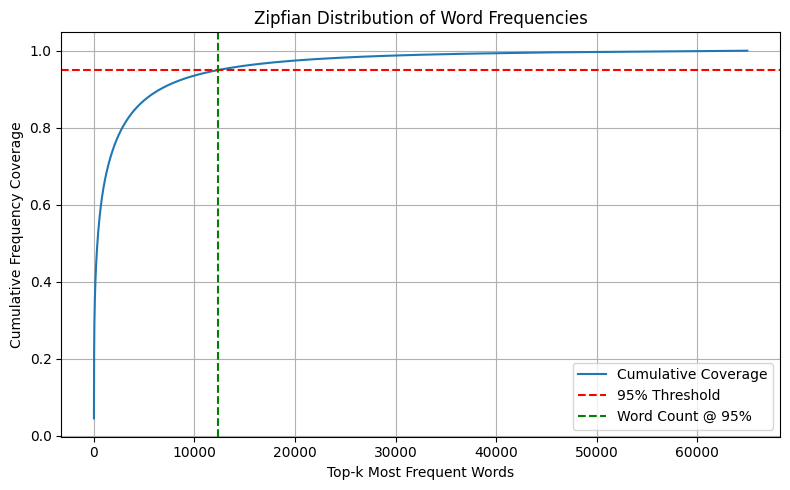

In [13]:
# --------------------------------------------
# Data Exploration 
# (Optional, but best practice) 
#    Sklearn CountVectorizer:
#        https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# --------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

trainDF = pd.read_csv("train.csv")
trainDF['text'] = trainDF['Title'].astype(str) + ' ' + trainDF['Description'].astype(str)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(trainDF['text'])

term_frequencies = np.asarray(X.sum(axis=0)).flatten()
sorted_frequencies = np.sort(term_frequencies)[::-1]
cumulative_freq = np.cumsum(sorted_frequencies) / np.sum(sorted_frequencies)
ranks = np.arange(1, len(sorted_frequencies) + 1)

# Number of words to reach 95% coverage
k_95 = np.argmax(cumulative_freq >= 0.95)
print(f"\nLexical threshold (k) capturing 95% of observed word frequency mass: {k_95} \n")

# Zipfian Curve
plt.figure(figsize=(8, 5))
plt.plot(cumulative_freq, label='Cumulative Coverage')
plt.axhline(0.95, color='red', linestyle='--', label='95% Threshold')
plt.axvline(np.argmax(cumulative_freq >= 0.95), color='green', linestyle='--', label='Word Count @ 95%')
plt.xlabel("Top-k Most Frequent Words")
plt.ylabel("Cumulative Frequency Coverage")
plt.title("Zipfian Distribution of Word Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



C:\Users\maria\AppData\Local\Temp\ipykernel_16328\1954080869.py:11: RuntimeWarning: invalid value encountered in power
  return C / ((r + beta) ** alpha)


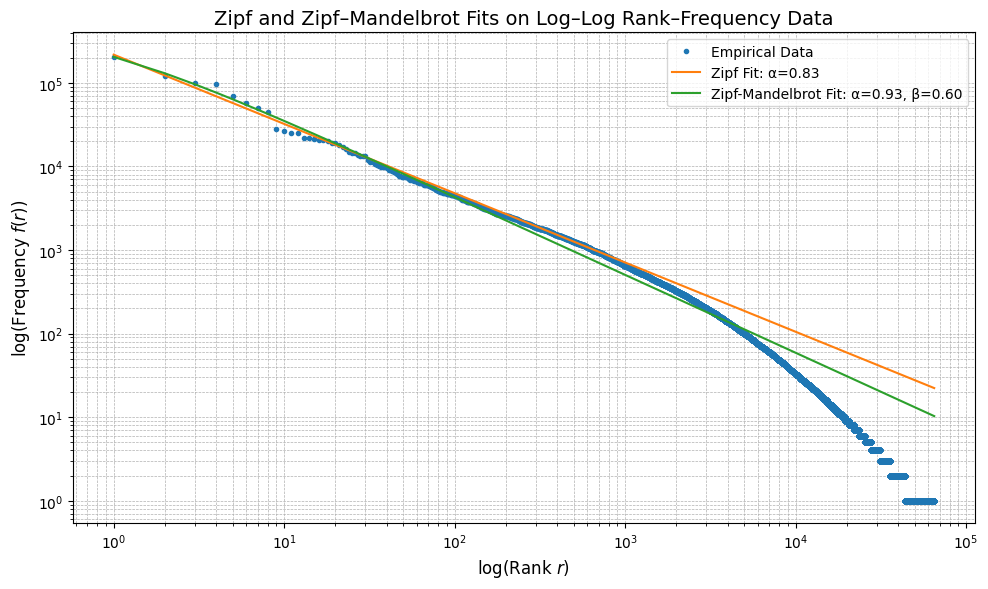

Zipf's Law Fit:
  C = 217753.19
  α = 0.829
  R² = 0.9839

Zipf–Mandelbrot Law Fit:
  C = 316864.97
  α = 0.932
  β = 0.597
  R² = 0.9906


In [11]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Zipf's Law model: f(r) = C / r^alpha
def zipf_law(r, C, alpha):
    return C / (r ** alpha)

# Zipf-Mandelbrot Law: f(r) = C / (r + beta)^alpha
def zipf_mandelbrot(r, C, alpha, beta):
    return C / ((r + beta) ** alpha)

# Fit Zipf's Law
popt_zipf, _ = curve_fit(zipf_law, ranks, sorted_frequencies, p0=[1e4, 1.0], maxfev=10000)

# Fit Zipf-Mandelbrot 
popt_mandelbrot, _ = curve_fit(zipf_mandelbrot, ranks, sorted_frequencies, p0=[1e4, 1.0, 2.0], maxfev=10000)

# Predict values for R² calculation
zipf_pred = zipf_law(ranks, *popt_zipf)
mandelbrot_pred = zipf_mandelbrot(ranks, *popt_mandelbrot)

# Compute R²: 1 - SS_res / SS_tot
def compute_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

r2_zipf = compute_r_squared(sorted_frequencies, zipf_pred)
r2_mandelbrot = compute_r_squared(sorted_frequencies, mandelbrot_pred)

# Rank-frequency on log-log scale with fitted models
plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_frequencies, label='Empirical Data', marker='.', linestyle='None')
plt.loglog(ranks, zipf_pred, label=f'Zipf Fit: α={popt_zipf[1]:.2f}')
plt.loglog(ranks, mandelbrot_pred, label=f'Zipf-Mandelbrot Fit: α={popt_mandelbrot[1]:.2f}, β={popt_mandelbrot[2]:.2f}')
plt.xlabel("log(Rank $r$)", fontsize=12)
plt.ylabel("log(Frequency $f(r)$)", fontsize=12)
plt.title("Zipf and Zipf–Mandelbrot Fits on Log–Log Rank–Frequency Data", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

print("Zipf's Law Fit:")
print(f"  C = {popt_zipf[0]:.2f}")
print(f"  α = {popt_zipf[1]:.3f}")
print(f"  R² = {r2_zipf:.4f}")

print("\nZipf–Mandelbrot Law Fit:")
print(f"  C = {popt_mandelbrot[0]:.2f}")
print(f"  α = {popt_mandelbrot[1]:.3f}")
print(f"  β = {popt_mandelbrot[2]:.3f}")
print(f"  R² = {r2_mandelbrot:.4f}")


# Step 1 (15%)
Build a text classifier using Term Frequency (TF) as the text representation and one of the classic learning algorithms, such as decision trees, Naïve Bayes, or Support Vector Machines(SVM). Report the accuracy for both the training and testing datasets. You must use both the Title and Description as the text input for each instance. Note that training SVM may take hours. 

Train Accuracy: 0.906717
Test Accuracy:  0.896447


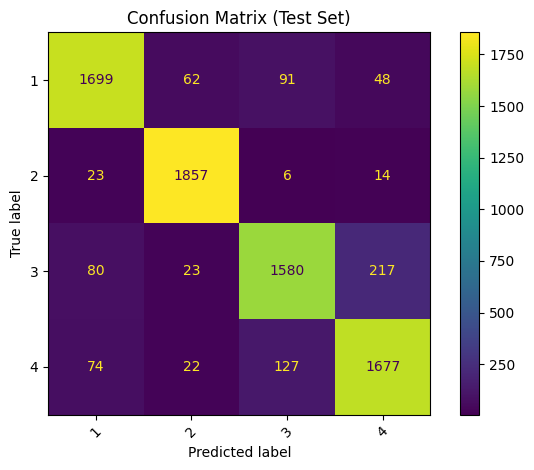

              precision    recall  f1-score   support

           1       0.91      0.89      0.90      1900
           2       0.95      0.98      0.96      1900
           3       0.88      0.83      0.85      1900
           4       0.86      0.88      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Test Log Loss: 1.1239

Top words for class 1:
that, said, 39, for, on, and, of, to, in, the

Top words for class 2:
with, at, on, for, 39, and, of, in, to, the

Top words for class 3:
reuters, its, 39, for, on, and, in, of, to, the

Top words for class 4:
is, 39, that, on, for, in, and, of, to, the


In [28]:
# --------------------------------------------
# TF-IDF Multinominal Naive Bayes Text Classifier: 
#    Sklearn CountVectorizer / NB:
#        https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#        https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
#    Max features chosen in preprocessing: 13,000
# --------------------------------------------

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

# Load data ----------------------
trainDF = pd.read_csv("train.csv")
testDF = pd.read_csv("test.csv")

# Combine 'Title' + 'Description' ----------------------
trainDF['text'] = trainDF['Title'].astype(str) + ' ' + trainDF['Description'].astype(str)
testDF['text'] = testDF['Title'].astype(str) + ' ' + testDF['Description'].astype(str)

# Vectorise (TF only, limit vocab size) ----------------------
vectorizer = CountVectorizer(max_features=13000)
X_train = vectorizer.fit_transform(trainDF['text'])  # sparse
X_test = vectorizer.transform(testDF['text'])

# Class labels
y_train = trainDF['Class Index']
y_test = testDF['Class Index']

# MultinomialNB ----------------------
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict and report accuracy ----------------------
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.6f}")
print(f"Test Accuracy:  {test_acc:.6f}")

# Best practice: 
#    Add confusion matrix, precision, recall, F1 score ----------------------
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

print(classification_report(y_test, clf.predict(X_test)))

# LL/NLL ----------------------
y_test_proba = clf.predict_proba(X_test)
test_log_loss = log_loss(y_test, y_test_proba, labels=clf.classes_)
print(f"Test Log Loss: {test_log_loss:.4f}")

# Top predictive words per class ----------------------
feature_names = np.array(vectorizer.get_feature_names_out())
for i, class_label in enumerate(clf.classes_):
    top10 = np.argsort(clf.feature_log_prob_[i])[-10:]
    print(f"\nTop words for class {class_label}:")
    print(", ".join(feature_names[top10]))

M1 = {
    "name": "Model 1 - NB on TF Representations",
    "train_acc": train_accs[-1],
    "test_acc": test_accs[-1],
    "test_log_loss": test_log_loss,
    "classification_report": classification_report(y_true, preds, output_dict=True),
    "confusion_matrix": confusion_matrix(y_true, preds)
}

# Step 2 (10%)
Build another text classifier by changing the text representation to TF-IDF while keeping the same classifier used in Step 1. Report the classification performance on the testing data, including the overall accuracy and the Precision, Recall, and F1 score for each class.

Train Accuracy: 0.908942
Test Accuracy:  0.897105


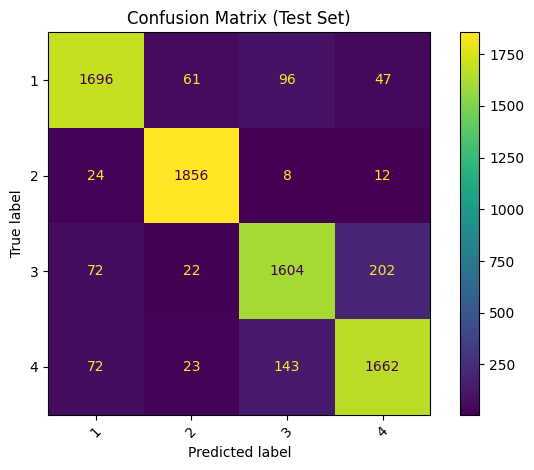

              precision    recall  f1-score   support

           1       0.91      0.89      0.90      1900
           2       0.95      0.98      0.96      1900
           3       0.87      0.84      0.86      1900
           4       0.86      0.87      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Test Log Loss: 0.3177

Top words for class 1:
said, 39, for, iraq, on, and, to, of, in, the

Top words for class 2:
on, at, his, and, for, of, 39, in, to, the

Top words for class 3:
reuters, its, 39, oil, and, on, of, in, to, the

Top words for class 4:
its, that, on, microsoft, for, in, and, of, to, the


In [29]:
# --------------------------------------------
# TF-IDF Multinominal Naive Bayes Text Classifier: 
#    Sklearn TfidfVectorizer / NB:
#        https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
#        https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
#    Max features chosen in preprocessing: 13,000
# --------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, log_loss

# Load data ----------------------
trainDF = pd.read_csv("train.csv")
testDF = pd.read_csv("test.csv")

# Combine 'Title' + 'Description' ----------------------
trainDF['text'] = trainDF['Title'].astype(str) + ' ' + trainDF['Description'].astype(str)
testDF['text'] = testDF['Title'].astype(str) + ' ' + testDF['Description'].astype(str)

# TF-IDF Vectorisation ----------------------
vectorizer = TfidfVectorizer(max_features=13000)
X_train = vectorizer.fit_transform(trainDF['text'])
X_test = vectorizer.transform(testDF['text'])

# Class labels ----------------------
y_train = trainDF['Class Index']
y_test = testDF['Class Index']

# Multinomial Naïve Bayes classifier ----------------------
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Evaluation Metrics ----------------------
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print(f"Train Accuracy: {train_acc:.6f}")
print(f"Test Accuracy:  {test_acc:.6f}")


ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


print(classification_report(y_test, clf.predict(X_test)))

# LL/NLL ----------------------
y_test_proba = clf.predict_proba(X_test)
test_log_loss = log_loss(y_test, y_test_proba, labels=clf.classes_)
print(f"Test Log Loss: {test_log_loss:.4f}")

# Top predictive words per class ----------------------
feature_names = np.array(vectorizer.get_feature_names_out())
for i, class_label in enumerate(clf.classes_):
    top10 = np.argsort(clf.feature_log_prob_[i])[-10:]
    print(f"\nTop words for class {class_label}:")
    print(", ".join(feature_names[top10]))


M2 = {
    "name": "Model 2 - NB on TF-IDF Representations",
    "train_acc": train_accs[-1],
    "test_acc": test_accs[-1],
    "test_log_loss": test_log_loss,
    "classification_report": classification_report(y_true, preds, output_dict=True),
    "confusion_matrix": confusion_matrix(y_true, preds)
}


# Step 3 (20%)
Build a text classifier using a Convolutional Neural Network (CNN). Initialize the embedding layer with random numbers and ensure it is trainable. Plot a figure showing how the accuracy changes during the training process for both the training and testing data. 

Epoch 1, Train Acc: 0.2500, Test Acc: 0.2539
Epoch 2, Train Acc: 0.2556, Test Acc: 0.2839
Epoch 3, Train Acc: 0.2945, Test Acc: 0.5479
Epoch 4, Train Acc: 0.5835, Test Acc: 0.6526
Epoch 5, Train Acc: 0.6949, Test Acc: 0.6975
Epoch 6, Train Acc: 0.7372, Test Acc: 0.7538
Epoch 7, Train Acc: 0.7912, Test Acc: 0.8049
Epoch 8, Train Acc: 0.8352, Test Acc: 0.8333
Epoch 9, Train Acc: 0.8637, Test Acc: 0.8545
Epoch 10, Train Acc: 0.8824, Test Acc: 0.8654
Epoch 11, Train Acc: 0.8960, Test Acc: 0.8749
Epoch 12, Train Acc: 0.9078, Test Acc: 0.8842
Epoch 13, Train Acc: 0.9168, Test Acc: 0.8887
Epoch 14, Train Acc: 0.9255, Test Acc: 0.8930
Epoch 15, Train Acc: 0.9329, Test Acc: 0.8972
Epoch 16, Train Acc: 0.9397, Test Acc: 0.8992
Epoch 17, Train Acc: 0.9457, Test Acc: 0.9020
Epoch 18, Train Acc: 0.9517, Test Acc: 0.9061
Epoch 19, Train Acc: 0.9573, Test Acc: 0.9074
Epoch 20, Train Acc: 0.9628, Test Acc: 0.9076
Epoch 21, Train Acc: 0.9678, Test Acc: 0.9074
Epoch 22, Train Acc: 0.9718, Test Acc: 0.90

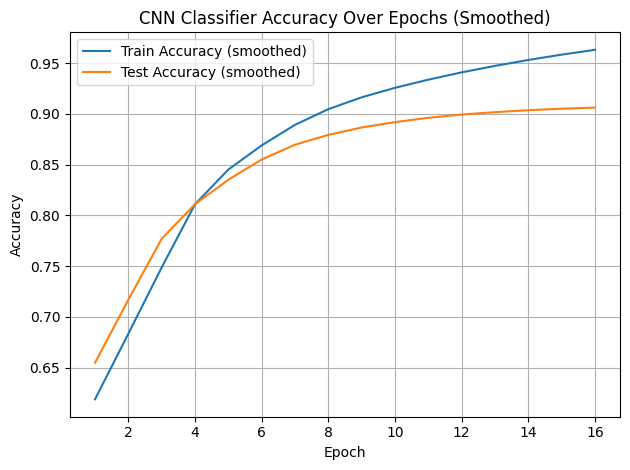


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1900
           1       0.96      0.96      0.96      1900
           2       0.87      0.88      0.87      1900
           3       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600

Log Loss: 0.3361

Confusion Matrix:


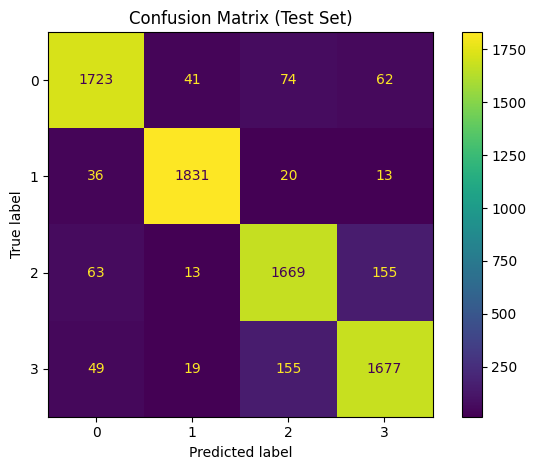

In [19]:
# --------------------------------------------
# CNN-based Text Classifier: 
#    JAX/Flax  
#    Bespoke embedding training 
#    Default parameters from class example 
#    Kernel size: 5 (from class example)
#    Necessary adaptations from class example:
#       Softmax ---> for multiclass (cross entropy)
# --------------------------------------------

import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax import linen as nn
from flax.training import train_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import time

# Data Preprocessing ----------------------
def tokenize(texts, vocab=None, unk_token="<UNK>", pad_token="<PAD>", max_len=70):
    tokenized = [t.lower().split() for t in texts]
    if vocab is None:
        tokens = [tok for doc in tokenized for tok in doc]
        counts = Counter(tokens)
        vocab = {word: i + 2 for i, (word, _) in enumerate(counts.items())}  # 0 reserved for PAD, 1 for UNK
        vocab[pad_token] = 0
        vocab[unk_token] = 1
    sequences = []
    for doc in tokenized:
        ids = [vocab.get(w, vocab[unk_token]) for w in doc[:max_len]]
        padded = ids + [vocab[pad_token]] * (max_len - len(ids))
        sequences.append(padded[:max_len])
    return jnp.array(sequences), vocab

# CNN Text Classifier ----------------------
class TextCNN(nn.Module):
    vocab_size: int
    embed_dim: int
    num_classes: int

    @nn.compact
    def __call__(self, x):
        emb = nn.Embed(self.vocab_size, self.embed_dim)(x)
        emb = emb.transpose((0, 2, 1))  # (batch, embed_dim, seq_len)
        conv = nn.Conv(features=128, kernel_size=(5,), strides=(1,), padding="VALID")(emb)
        conv = nn.relu(conv)
        pooled = jnp.mean(conv, axis=-1)  # global average pooling (class example)
        out = nn.Dense(self.num_classes)(pooled)
        return out

# Training Setup ----------------------
def cross_entropy_loss(logits, labels): # cross entropy loss
    one_hot = jax.nn.one_hot(labels, num_classes=logits.shape[-1])
    return optax.softmax_cross_entropy(logits=logits, labels=one_hot).mean()

def compute_metrics(logits, labels):
    predictions = jnp.argmax(logits, axis=-1)
    acc = jnp.mean(predictions == labels)
    return acc

def create_train_state(rng, model, learning_rate):
    params = model.init(rng, jnp.ones((1, 70), jnp.int32))
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Main Training Loop ----------------------
def train_model(trainX, trainY, testX, testY, vocab_size, num_classes, num_epochs=25):
    model = TextCNN(vocab_size=vocab_size, embed_dim=128, num_classes=num_classes)
    rng = jax.random.PRNGKey(0)
    state = create_train_state(rng, model, learning_rate=0.01)

    train_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        def loss_fn(params):
            logits = model.apply(params, trainX)
            return cross_entropy_loss(logits, trainY), logits
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, logits), grads = grad_fn(state.params)
        state = state.apply_gradients(grads=grads)

        train_acc = compute_metrics(logits, trainY)
        test_logits = model.apply(state.params, testX)
        test_acc = compute_metrics(test_logits, testY)

        train_accs.append(float(train_acc))
        test_accs.append(float(test_acc))
        print(f"Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return state, train_accs, test_accs, model

# Data Loading & Execution ----------------------
start_time = time.time()

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_texts = train_df['Title'].astype(str) + ' ' + train_df['Description'].astype(str)
test_texts = test_df['Title'].astype(str) + ' ' + test_df['Description'].astype(str)

trainX, vocab = tokenize(train_texts.tolist(), max_len=70)
testX, _ = tokenize(test_texts.tolist(), vocab=vocab, max_len=70)

le = LabelEncoder()
trainY = jnp.array(le.fit_transform(train_df['Class Index']))
testY = jnp.array(le.transform(test_df['Class Index']))

state, train_accs, test_accs, model = train_model(trainX, trainY, testX, testY, vocab_size=len(vocab), num_classes=4, num_epochs=25)

end_time = time.time()
print(f"\nTotal training time: {end_time - start_time:.2f} seconds.\n")

# Accuracy Plot (Rolling Average for smoothing) ----------------------
def moving_average(data, window_size=6):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_train = moving_average(train_accs, window_size=10)
smoothed_test = moving_average(test_accs, window_size=10)

epochs = np.arange(len(smoothed_train)) + 1

plt.plot(epochs, smoothed_train, label='Train Accuracy (smoothed)')
plt.plot(epochs, smoothed_test, label='Test Accuracy (smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Classifier Accuracy Over Epochs (Smoothed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation Metrics ----------------------
final_logits = model.apply(state.params, testX)
preds = np.array(jnp.argmax(final_logits, axis=-1))
y_true = np.array(testY)

print("\nClassification Report:")
print(classification_report(y_true, preds))

probs = jax.nn.softmax(final_logits, axis=-1)
test_log_loss = log_loss(y_true, probs, labels=np.unique(y_true))
print(f"Log Loss: {test_log_loss:.4f}")

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true, preds)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

M3 = {
    "name": "Model 3 - CNN with Trainable Embeddings",
    "train_acc": train_accs[-1],
    "test_acc": test_accs[-1],
    "test_log_loss": test_log_loss,
    "classification_report": classification_report(y_true, preds, output_dict=True),
    "confusion_matrix": confusion_matrix(y_true, preds)
}


# Step 4 (20%)
Create a new version of the CNN-based text classifier using pre-trained word embeddings such as GloVe. Report the accuracy on the testing data and draw the confusion matrix for this model.  

Epoch 1, Train Acc: 0.2414, Test Acc: 0.2445
Epoch 2, Train Acc: 0.2651, Test Acc: 0.2734
Epoch 3, Train Acc: 0.2864, Test Acc: 0.2713
Epoch 4, Train Acc: 0.2837, Test Acc: 0.4239
Epoch 5, Train Acc: 0.4716, Test Acc: 0.3776
Epoch 6, Train Acc: 0.4031, Test Acc: 0.4479
Epoch 7, Train Acc: 0.4923, Test Acc: 0.6483
Epoch 8, Train Acc: 0.7353, Test Acc: 0.5836
Epoch 9, Train Acc: 0.6801, Test Acc: 0.5946
Epoch 10, Train Acc: 0.6797, Test Acc: 0.6867
Epoch 11, Train Acc: 0.7602, Test Acc: 0.7553
Epoch 12, Train Acc: 0.8171, Test Acc: 0.7766
Epoch 13, Train Acc: 0.8321, Test Acc: 0.7697
Epoch 14, Train Acc: 0.8234, Test Acc: 0.8038
Epoch 15, Train Acc: 0.8554, Test Acc: 0.8355
Epoch 16, Train Acc: 0.8846, Test Acc: 0.8363
Epoch 17, Train Acc: 0.8812, Test Acc: 0.8383
Epoch 18, Train Acc: 0.8831, Test Acc: 0.8521
Epoch 19, Train Acc: 0.8944, Test Acc: 0.8611
Epoch 20, Train Acc: 0.8983, Test Acc: 0.8628
Epoch 21, Train Acc: 0.9009, Test Acc: 0.8700
Epoch 22, Train Acc: 0.9100, Test Acc: 0.87

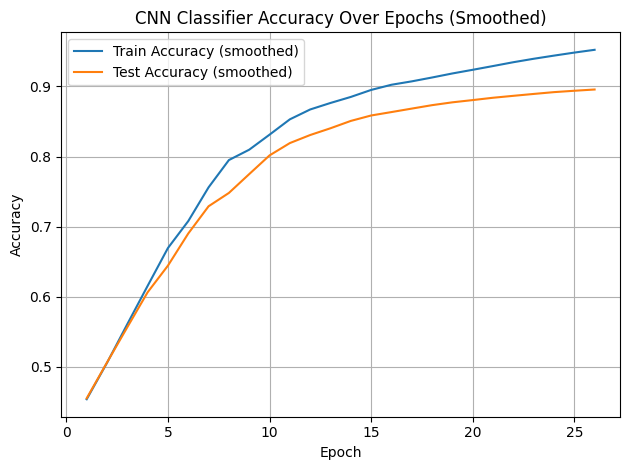


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1900
           1       0.96      0.96      0.96      1900
           2       0.88      0.85      0.86      1900
           3       0.87      0.88      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Log Loss: 0.2884

Confusion Matrix:


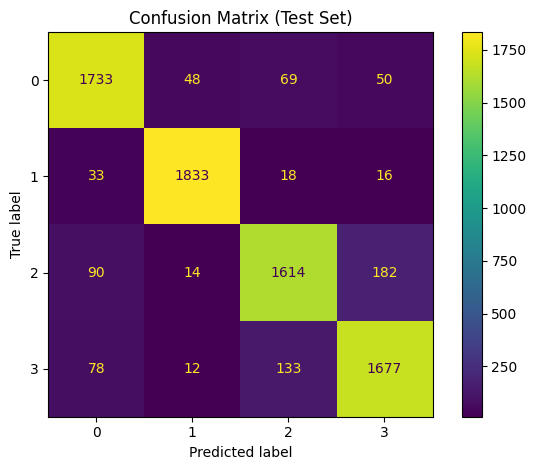

In [32]:
# --------------------------------------------
# CNN-based Text Classifier: 
#    JAX/Flax  
#    GloVe Embeddings:
#        https://nlp.stanford.edu/projects/glove/
#    Improved parameters (from step 5)
#
#    Other references:
#        1 - https://flax-linen.readthedocs.io/en/latest/api_reference/flax.linen/module.html
#        2 - https://coderzcolumn.com/tutorials/artificial-intelligence/flax-jax-text-classification-using-glove-embeddings 
# --------------------------------------------

import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax import linen as nn
from flax.training import train_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import time

# Load GloVe Embeddings ----------------------
def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Data Preprocessing ----------------------
def tokenize(texts, vocab=None, unk_token="<UNK>", pad_token="<PAD>", max_len=53):
    tokenized = [t.lower().split() for t in texts]
    if vocab is None:
        tokens = [tok for doc in tokenized for tok in doc]
        counts = Counter(tokens)
        vocab = {word: i + 2 for i, (word, _) in enumerate(counts.items())}  # 0 reserved for PAD, 1 for UNK
        vocab[pad_token] = 0
        vocab[unk_token] = 1
    sequences = []
    for doc in tokenized:
        ids = [vocab.get(w, vocab[unk_token]) for w in doc[:max_len]]
        padded = ids + [vocab[pad_token]] * (max_len - len(ids))
        sequences.append(padded[:max_len])
    return jnp.array(sequences), vocab

# CNN (Pretrained Embeddings) ----------------------
class TextCNNPretrained(nn.Module):
    embedding_matrix: jnp.ndarray
    num_classes: int

    @nn.compact
    def __call__(self, x):
        emb = nn.Embed(self.embedding_matrix.shape[0], self.embedding_matrix.shape[1], embedding_init=lambda *_: self.embedding_matrix, name="embed", dtype=jnp.float32)(x)
        emb = emb.transpose((0, 2, 1))
        conv = nn.Conv(features=64, kernel_size=(3,), strides=(1,), padding="VALID")(emb)
        conv = nn.relu(conv)
        pooled = jnp.max(conv, axis=-1) # max pooling (preference)
        out = nn.Dense(self.num_classes)(pooled)
        return out

# Training Setup ----------------------
def cross_entropy_loss(logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=logits.shape[-1])
    return optax.softmax_cross_entropy(logits=logits, labels=one_hot).mean()

def compute_metrics(logits, labels):
    predictions = jnp.argmax(logits, axis=-1)
    acc = jnp.mean(predictions == labels)
    return acc

def create_train_state(rng, model, learning_rate):
    params = model.init(rng, jnp.ones((1, 53), jnp.int32))
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Training Loop ----------------------
def train_model(trainX, trainY, testX, testY, embedding_matrix, num_classes, num_epochs=35):
    model = TextCNNPretrained(embedding_matrix=jnp.array(embedding_matrix), num_classes=num_classes)
    rng = jax.random.PRNGKey(0)
    state = create_train_state(rng, model, learning_rate=0.01)

    train_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        def loss_fn(params):
            logits = model.apply(params, trainX)
            return cross_entropy_loss(logits, trainY), logits
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, logits), grads = grad_fn(state.params)
        state = state.apply_gradients(grads=grads)

        train_acc = compute_metrics(logits, trainY)
        test_logits = model.apply(state.params, testX)
        test_acc = compute_metrics(test_logits, testY)

        train_accs.append(float(train_acc))
        test_accs.append(float(test_acc))
        print(f"Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return state, train_accs, test_accs, model

# Load Data ----------------------
start_time = time.time()

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_texts = train_df['Title'].astype(str) + ' ' + train_df['Description'].astype(str)
test_texts = test_df['Title'].astype(str) + ' ' + test_df['Description'].astype(str)

trainX, vocab = tokenize(train_texts.tolist(), max_len=53)
testX, _ = tokenize(test_texts.tolist(), vocab=vocab, max_len=53)

embedding_dim = 100
glove_path = "glove.6B.100d.txt" 
glove_embeddings = load_glove_embeddings(glove_path, embedding_dim)

embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in vocab.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

le = LabelEncoder()
trainY = jnp.array(le.fit_transform(train_df['Class Index']))
testY = jnp.array(le.transform(test_df['Class Index']))

state, train_accs, test_accs, model = train_model(trainX, trainY, testX, testY, embedding_matrix=embedding_matrix, num_classes=4)

end_time = time.time()
print(f"\nTotal training time: {end_time - start_time:.2f} seconds\n")

# Accuracy Plot ----------------------
def moving_average(data, window_size=6):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_train = moving_average(train_accs, window_size=10)
smoothed_test = moving_average(test_accs, window_size=10)

epochs = np.arange(len(smoothed_train)) + 1

plt.plot(epochs, smoothed_train, label='Train Accuracy (smoothed)')
plt.plot(epochs, smoothed_test, label='Test Accuracy (smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Classifier Accuracy Over Epochs (Smoothed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation ----------------------
final_logits = model.apply(state.params, testX)
preds = np.array(jnp.argmax(final_logits, axis=-1))
y_true = np.array(testY)

print("\nClassification Report:")
print(classification_report(y_true, preds))

probs = jax.nn.softmax(final_logits, axis=-1)
test_log_loss = log_loss(y_true, probs, labels=np.unique(y_true))
print(f"Log Loss: {test_log_loss:.4f}")

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true, preds)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

M4 = {
    "name": "Model 4 - CNN with 6B 100d GloVe (Pretrained Embeddings)",
    "train_acc": train_accs[-1],
    "test_acc": test_accs[-1],
    "test_log_loss": test_log_loss,
    "classification_report": classification_report(y_true, preds, output_dict=True),
    "confusion_matrix": confusion_matrix(y_true, preds)
}


# Step 5 (20%)
Create a third version of the CNN-based classifier by applying techniques such as data preprocessing, hyperparameter tuning, changing classifiers, or modifying text representations. Note: The testing data must not be used for tuning; it should only be used for final evaluation. 

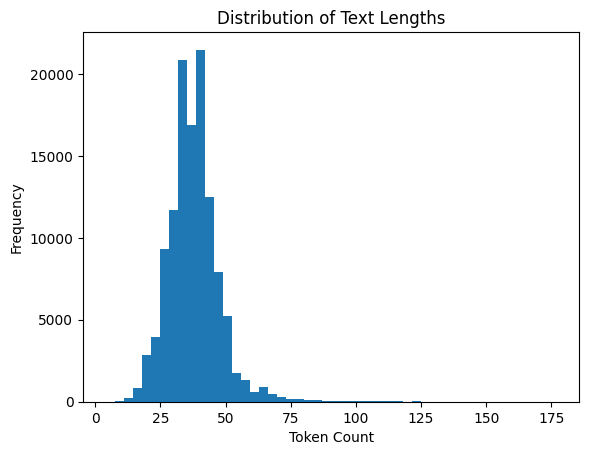

50th percentile: 37 tokens
75th percentile: 43 tokens
90th percentile: 48 tokens
95th percentile: 53 tokens
99th percentile: 70 tokens
100th percentile: 177 tokens


In [33]:
# --------------------------------------------------
# Lower to 95th-percentile threshold for performance
# --------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

lengths = [len(text.split()) for text in train_df['Title'] + ' ' + train_df['Description']]
plt.hist(lengths, bins=50)
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.show()

# Combine + tokenize
combined_texts = (train_df['Title'] + ' ' + train_df['Description']).astype(str)
lengths = [len(text.lower().split()) for text in combined_texts]

# Compute percentiles
percentiles = [50, 75, 90, 95, 99, 100]
results = np.percentile(lengths, percentiles)

for p, val in zip(percentiles, results):
    print(f"{p}th percentile: {int(val)} tokens")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1, Train Acc: 0.2451, Validation Acc: 0.2560
Epoch 2, Train Acc: 0.2655, Validation Acc: 0.2841
Epoch 3, Train Acc: 0.2967, Validation Acc: 0.3438
Epoch 4, Train Acc: 0.3677, Validation Acc: 0.4062
Epoch 5, Train Acc: 0.4250, Validation Acc: 0.4529
Epoch 6, Train Acc: 0.4768, Validation Acc: 0.5792
Epoch 7, Train Acc: 0.6087, Validation Acc: 0.6984
Epoch 8, Train Acc: 0.7344, Validation Acc: 0.7170
Epoch 9, Train Acc: 0.7470, Validation Acc: 0.7367
Epoch 10, Train Acc: 0.7636, Validation Acc: 0.7873
Epoch 11, Train Acc: 0.8110, Validation Acc: 0.8226
Epoch 12, Train Acc: 0.8416, Validation Acc: 0.8248
Epoch 13, Train Acc: 0.8410, Validation Acc: 0.8325
Epoch 14, Train Acc: 0.8477, Validation Acc: 0.8554
Epoch 15, Train Acc: 0.8679, Validation Acc: 0.8641
Epoch 16, Train Acc: 0.8776, Validation Acc: 0.8621
Epoch 17, Train Acc: 0.8786, Validation Acc: 0.8698
Epoch 18, Train Acc: 0.8851, Validation Acc: 0.8776
Epoch 19, Train Acc: 0.8931, Validation Acc: 0.8825
Epoch 20, Train Acc: 

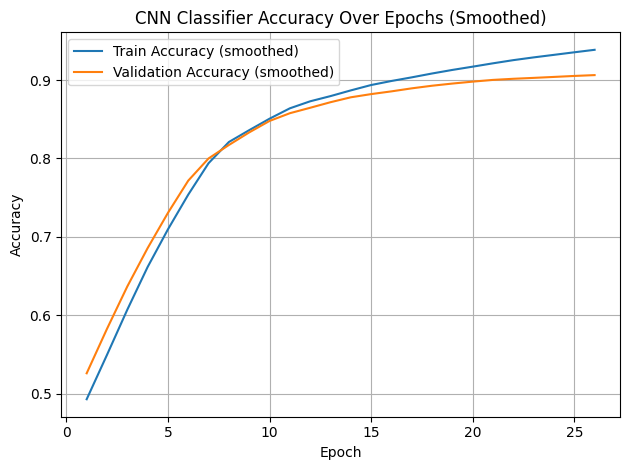


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1900
           1       0.96      0.97      0.96      1900
           2       0.88      0.85      0.87      1900
           3       0.87      0.89      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Log Loss: 0.2973

Confusion Matrix:


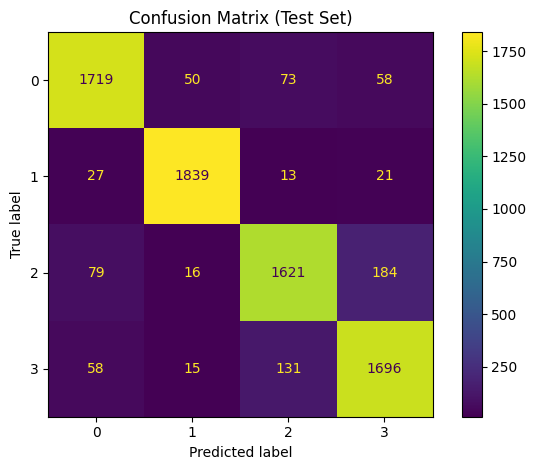

In [34]:
# --------------------------------------------
# CNN-based Text Classifier: 
#    JAX/Flax  
#    GloVe Embeddings 
#    Improved parameters
#    Data Preprocessing 
#    Validation Split
#
#    Other references:
#        1 - https://flax-linen.readthedocs.io/en/latest/api_reference/flax.linen/module.html
#        2 - https://www.nltk.org/api/nltk.corpus.html#module-nltk.corpus
#        3 - https://www.nltk.org/api/nltk.stem.html#module-nltk.stem
# --------------------------------------------

import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax import linen as nn
from flax.training import train_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

# Load GloVe Embeddings ----------------------
def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Data Preprocessing ----------------------
def clean_and_tokenize(texts, stop_words, stemmer, rare_threshold=2):
    tokenized_texts = []
    token_freq = Counter()
    for t in texts:
        t = re.sub(r"[^a-zA-Z\s]", "", t.lower())
        tokens = [stemmer.stem(w) for w in t.split() if w not in stop_words]
        tokenized_texts.append(tokens)
        token_freq.update(tokens)
    # Remove rare tokens:
    filtered_texts = [[tok for tok in doc if token_freq[tok] >= rare_threshold] for doc in tokenized_texts]
    return filtered_texts

def tokenize_from_cleaned(tokenized, vocab=None, unk_token="<UNK>", pad_token="<PAD>", max_len=53):
    if vocab is None:
        tokens = [tok for doc in tokenized for tok in doc]
        counts = Counter(tokens)
        vocab = {word: i + 2 for i, (word, _) in enumerate(counts.items())}
        vocab[pad_token] = 0
        vocab[unk_token] = 1
    sequences = []
    for doc in tokenized:
        ids = [vocab.get(w, vocab[unk_token]) for w in doc[:max_len]]
        padded = ids + [vocab[pad_token]] * (max_len - len(ids))
        sequences.append(padded[:max_len])
    return jnp.array(sequences), vocab

# CNN with Pretrained Embeddings ----------------------
class TextCNNPretrained(nn.Module):
    embedding_matrix: jnp.ndarray
    num_classes: int

    @nn.compact
    def __call__(self, x):
        emb = nn.Embed(self.embedding_matrix.shape[0], self.embedding_matrix.shape[1], embedding_init=lambda *_: self.embedding_matrix, name="embed", dtype=jnp.float32)(x)
        emb = emb.transpose((0, 2, 1))
        conv = nn.Conv(features=64, kernel_size=(3,), strides=(1,), padding="VALID")(emb)
        conv = nn.relu(conv)
        pooled = jnp.max(conv, axis=-1)
        out = nn.Dense(self.num_classes)(pooled)
        return out

# Training Setup ----------------------
def cross_entropy_loss(logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=logits.shape[-1])
    return optax.softmax_cross_entropy(logits=logits, labels=one_hot).mean()

def compute_metrics(logits, labels):
    predictions = jnp.argmax(logits, axis=-1)
    acc = jnp.mean(predictions == labels)
    return acc

def create_train_state(rng, model, learning_rate):
    params = model.init(rng, jnp.ones((1, 53), jnp.int32))
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Training Loop ----------------------
def train_model(trainX, trainY, validX, validY, embedding_matrix, num_classes, num_epochs=35):
    model = TextCNNPretrained(embedding_matrix=jnp.array(embedding_matrix), num_classes=num_classes)
    rng = jax.random.PRNGKey(0)
    state = create_train_state(rng, model, learning_rate=0.01)

    train_accs = []
    valid_accs = []

    for epoch in range(num_epochs):
        def loss_fn(params):
            logits = model.apply(params, trainX)
            return cross_entropy_loss(logits, trainY), logits
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, logits), grads = grad_fn(state.params)
        state = state.apply_gradients(grads=grads)

        train_acc = compute_metrics(logits, trainY)
        valid_logits = model.apply(state.params, validX)
        valid_acc = compute_metrics(valid_logits, validY)

        train_accs.append(float(train_acc))
        valid_accs.append(float(valid_acc))
        print(f"Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Validation Acc: {valid_acc:.4f}")

    return state, train_accs, valid_accs, model

# ---------------------- Load and Process Data ----------------------
start_time = time.time()

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_texts_raw = train_df['Title'].astype(str) + ' ' + train_df['Description'].astype(str)
test_texts_raw = test_df['Title'].astype(str) + ' ' + test_df['Description'].astype(str)

train_texts_clean = clean_and_tokenize(train_texts_raw.tolist(), stop_words, stemmer)
test_texts_clean = clean_and_tokenize(test_texts_raw.tolist(), stop_words, stemmer)

X_all, vocab = tokenize_from_cleaned(train_texts_clean)
X_test, _ = tokenize_from_cleaned(test_texts_clean, vocab=vocab)

embedding_dim = 100
glove_path = "glove.6B.100d.txt"
glove_embeddings = load_glove_embeddings(glove_path, embedding_dim)

embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in vocab.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

le = LabelEncoder()
y_all = jnp.array(le.fit_transform(train_df['Class Index']))
y_test = jnp.array(le.transform(test_df['Class Index']))

X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.1, random_state=42)

state, train_accs, val_accs, model = train_model(X_train, y_train, X_val, y_val, embedding_matrix=embedding_matrix, num_classes=4)

end_time = time.time()
print(f"\nTotal training time: {end_time - start_time:.2f} seconds")

# ---------------------- Accuracy Plot ----------------------
def moving_average(data, window_size=6):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_train = moving_average(train_accs, window_size=10)
smoothed_val = moving_average(val_accs, window_size=10)

epochs = np.arange(len(smoothed_train)) + 1

plt.plot(epochs, smoothed_train, label='Train Accuracy (smoothed)')
plt.plot(epochs, smoothed_val, label='Validation Accuracy (smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Classifier Accuracy Over Epochs (Smoothed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------- Evaluation on Test Set ----------------------
final_logits = model.apply(state.params, X_test)
preds = np.array(jnp.argmax(final_logits, axis=-1))
y_true = np.array(y_test)

print("\nClassification Report:")
print(classification_report(y_true, preds))

probs = jax.nn.softmax(final_logits, axis=-1)
test_log_loss = log_loss(y_true, probs, labels=np.unique(y_true))
print(f"Log Loss: {test_log_loss:.4f}")

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true, preds)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

M5 = {
    "name": "Model 5 - CNN with 6B 100d GloVe and Preprocessing",
    "train_acc": train_accs[-1],
    "val_acc": val_accs[-1],
    "test_log_loss": test_log_loss,
    "classification_report": classification_report(y_true, preds, output_dict=True),
    "confusion_matrix": confusion_matrix(y_true, preds)
}


# Step 6 (5%)
Display a summary that reports the test accuracy of all models from Steps 1 to 5. 


Model Summary Table:
Model  Train Accuracy  Test Accuracy  Log Loss  Macro F1
   M1        0.980517       0.907895  1.123935  0.907944
   M2        0.980517       0.907895  0.317650  0.907944
   M3        0.980517       0.907895  0.336083  0.907944
   M4        0.969158       0.902237  0.288449  0.902083
   M5        0.951111       0.909667  0.297256  0.904481



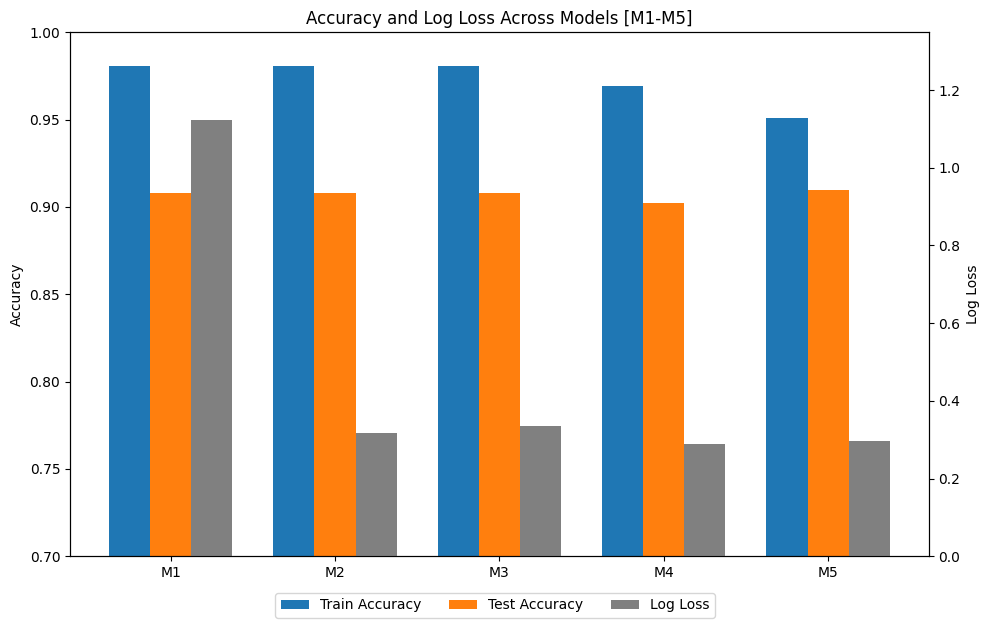

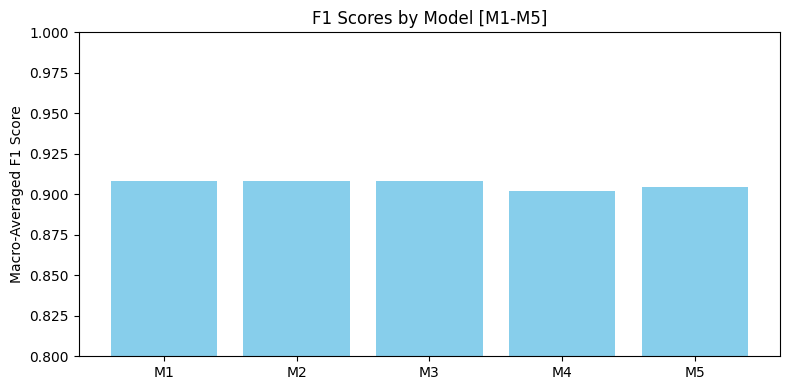

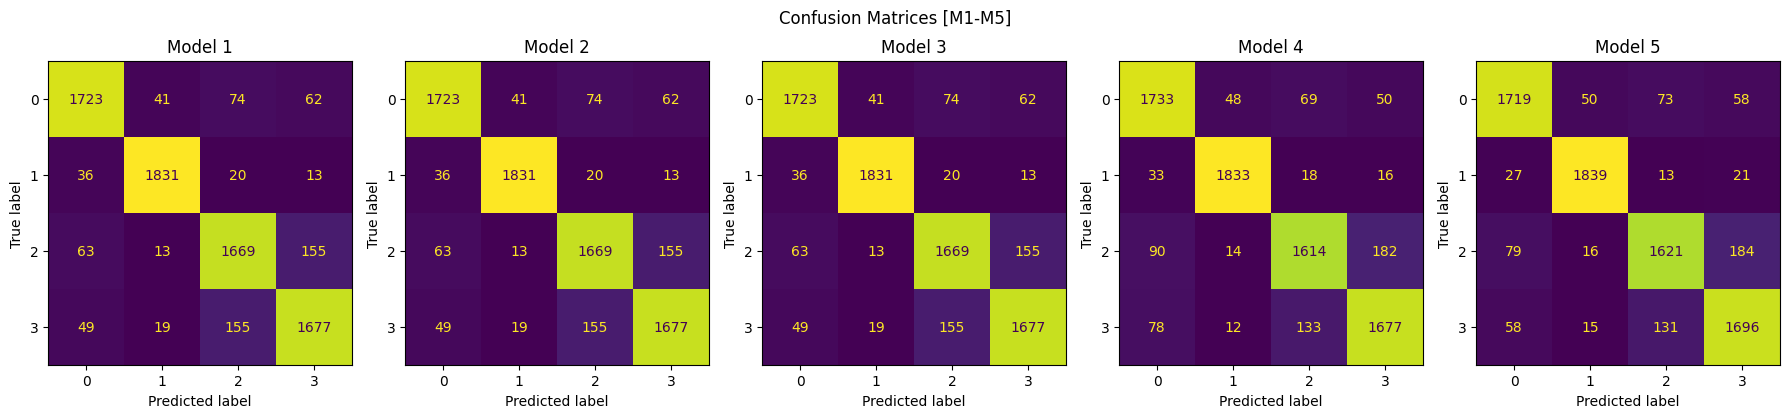

In [43]:
# --------------------------------------------
# Visual comparison of all models
# --------------------------------------------

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

models = [M1, M2, M3, M4, M5]

summary_data = {
    'Model': [f"M{i+1}" for i in range(len(models))],
    'Train Accuracy': train_acc,
    'Test Accuracy': test_acc,
    'Log Loss': log_losses,
    'Macro F1': f1_macro
}
summary_df = pd.DataFrame(summary_data)
print("\nModel Summary Table:")
print(summary_df.to_string(index=False))
print("")

# Accuracy / LL ----------------------
names = [m['name'] for m in models]
train_acc = [m['train_acc'] for m in models]
test_acc = [m.get('test_acc', m.get('val_acc')) for m in models]
log_losses = [m['test_log_loss'] for m in models]

x = np.arange(len(models))
width = 0.25

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(x - width, train_acc, width, label='Train Accuracy')
ax1.bar(x, test_acc, width, label='Test Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.7, 1.0)

ax2 = ax1.twinx()
ax2.bar(x + width, log_losses, width, label='Log Loss', color='gray')
ax2.set_ylabel('Log Loss')
ax2.set_ylim(0, max(log_losses)*1.2)

ax1.set_xticks(x)
ax1.set_xticklabels([f"M{i+1}" for i in range(len(models))])
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.title("Accuracy and Log Loss Across Models [M1-M5]")
plt.tight_layout()
plt.show()

# F1-scores ----------------------
f1_macro = [m['classification_report']['macro avg']['f1-score'] for m in models]
plt.figure(figsize=(8, 4))
plt.bar([f"M{i+1}" for i in range(len(models))], f1_macro, color='skyblue')
plt.ylabel("Macro-Averaged F1 Score")
plt.title("F1 Scores by Model [M1-M5]")
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

# Confusion Matrices ----------------------
fig, axes = plt.subplots(1, len(models), figsize=(18, 4))
for i, m in enumerate(models):
    disp = ConfusionMatrixDisplay(m['confusion_matrix'])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(f"{m['name'].split('-')[0].strip()}")
plt.suptitle("Confusion Matrices [M1-M5]")
plt.tight_layout()
plt.show()



# PyTorch Implementation
## To the marker: 
* I wrote the original code in JAX, then asked ChatGPT to refactor the solution as a PyTorch implementation (much slower) in case you have issues running the JAX version. This won't be included in the report. Thanks! 


Epoch 1, Train Acc: 0.8522, Test Acc: 0.8784
Epoch 2, Train Acc: 0.9218, Test Acc: 0.8982
Epoch 3, Train Acc: 0.9475, Test Acc: 0.8757
Epoch 4, Train Acc: 0.9581, Test Acc: 0.8855
Epoch 5, Train Acc: 0.9669, Test Acc: 0.8830
Epoch 6, Train Acc: 0.9724, Test Acc: 0.8701
Epoch 7, Train Acc: 0.9753, Test Acc: 0.8828
Epoch 8, Train Acc: 0.9775, Test Acc: 0.8793
Epoch 9, Train Acc: 0.9817, Test Acc: 0.8837
Epoch 10, Train Acc: 0.9821, Test Acc: 0.8771
Epoch 11, Train Acc: 0.9854, Test Acc: 0.8836
Epoch 12, Train Acc: 0.9857, Test Acc: 0.8787
Epoch 13, Train Acc: 0.9872, Test Acc: 0.8882
Epoch 14, Train Acc: 0.9875, Test Acc: 0.8878
Epoch 15, Train Acc: 0.9896, Test Acc: 0.8868
Epoch 16, Train Acc: 0.9894, Test Acc: 0.8846
Epoch 17, Train Acc: 0.9897, Test Acc: 0.8830
Epoch 18, Train Acc: 0.9909, Test Acc: 0.8867
Epoch 19, Train Acc: 0.9910, Test Acc: 0.8870
Epoch 20, Train Acc: 0.9919, Test Acc: 0.8854
Epoch 21, Train Acc: 0.9922, Test Acc: 0.8836
Epoch 22, Train Acc: 0.9921, Test Acc: 0.89

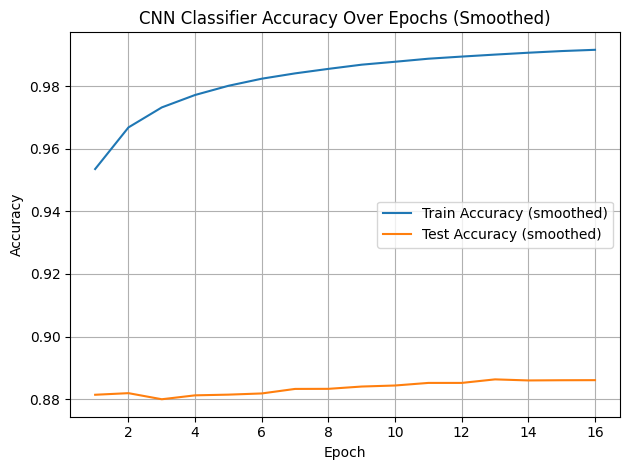


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1900
           1       0.94      0.97      0.95      1900
           2       0.83      0.87      0.85      1900
           3       0.88      0.83      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Log Loss: 0.2884

Confusion Matrix:


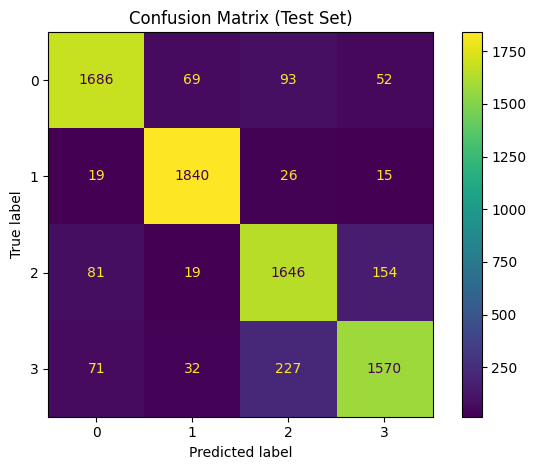

In [38]:
#### Equivalent PyTorch Implementation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss
import matplotlib.pyplot as plt
from collections import Counter
import time


def tokenize(texts, vocab=None, unk_token="<UNK>", pad_token="<PAD>", max_len=53):
    tokenized = [t.lower().split() for t in texts]
    if vocab is None:
        tokens = [tok for doc in tokenized for tok in doc]
        counts = Counter(tokens)
        vocab = {word: i + 2 for i, (word, _) in enumerate(counts.items())} 
        vocab[pad_token] = 0
        vocab[unk_token] = 1
    sequences = []
    for doc in tokenized:
        ids = [vocab.get(w, vocab[unk_token]) for w in doc[:max_len]]
        padded = ids + [vocab[pad_token]] * (max_len - len(ids))
        sequences.append(padded[:max_len])
    return torch.tensor(sequences, dtype=torch.long), vocab


class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, 64, kernel_size=3)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  
        x = F.relu(self.conv(x))
        x = F.max_pool1d(x, kernel_size=x.size(2)).squeeze(2)
        x = self.fc(x)
        return x


def train_model(train_loader, test_loader, model, num_epochs=25, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_accs, test_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            correct += (output.argmax(1) == yb).sum().item()
            total += yb.size(0)
        train_acc = correct / total

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                correct += (output.argmax(1) == yb).sum().item()
                total += yb.size(0)
        test_acc = correct / total

        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print(f"Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return model, train_accs, test_accs

start_time = time.time()

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_texts = train_df['Title'].astype(str) + ' ' + train_df['Description'].astype(str)
test_texts = test_df['Title'].astype(str) + ' ' + test_df['Description'].astype(str)

trainX, vocab = tokenize(train_texts.tolist(), max_len=53)
testX, _ = tokenize(test_texts.tolist(), vocab=vocab, max_len=53)

le = LabelEncoder()
trainY = torch.tensor(le.fit_transform(train_df['Class Index']), dtype=torch.long)
testY = torch.tensor(le.transform(test_df['Class Index']), dtype=torch.long)

batch_size = 64
train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = TextCNN(vocab_size=len(vocab), embed_dim=128, num_classes=4)
model, train_accs, test_accs = train_model(train_loader, test_loader, model)
end_time = time.time()
print(f"\nTotal training time: {end_time - start_time:.2f} seconds\n")

def moving_average(data, window_size=6):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_train = moving_average(train_accs, window_size=10)
smoothed_test = moving_average(test_accs, window_size=10)

epochs = np.arange(len(smoothed_train)) + 1

plt.plot(epochs, smoothed_train, label='Train Accuracy (smoothed)')
plt.plot(epochs, smoothed_test, label='Test Accuracy (smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Classifier Accuracy Over Epochs (Smoothed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        output = model(xb)
        preds = output.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

probs = jax.nn.softmax(final_logits, axis=-1)
test_log_loss = log_loss(y_true, probs, labels=np.unique(y_true))
print(f"Log Loss: {test_log_loss:.4f}")

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

In [ ]:
# CNN-based Text Classifier using JAX + Flax with GloVe Embeddings + Preprocessing + Validation Split

# --- Import dependencies ---
import jax  # Main JAX library
import jax.numpy as jnp  # JAX's version of NumPy
import numpy as np  # NumPy for general numerical ops
import optax  # Optimizer library for JAX
from flax import linen as nn  # Flax neural network module
from flax.training import train_state  # For managing model + optimizer state
from sklearn.model_selection import train_test_split  # For splitting data into train/validation
from sklearn.preprocessing import LabelEncoder  # Converts labels to integers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss  # Evaluation metrics
from collections import Counter  # Frequency counting
import matplotlib.pyplot as plt  # Plotting
import pandas as pd  # Data handling
import time  # Timing
import re  # Regex for text cleaning
import nltk  # Natural Language Toolkit
from nltk.corpus import stopwords  # Stopword list
from nltk.stem import PorterStemmer  # Classic stemmer
nltk.download('stopwords')  # Ensure stopwords are downloaded

# ---------------------- Load GloVe Embeddings ----------------------
def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()  # Split the line into word + vector
            word = values[0]  # First token is the word
            coefs = np.asarray(values[1:], dtype='float32')  # Remaining tokens are vector floats
            embeddings_index[word] = coefs  # Store in dictionary
    return embeddings_index

# ---------------------- Data Preprocessing ----------------------
def clean_and_tokenize(texts, stop_words, stemmer, rare_threshold=2):
    tokenized_texts = []  # List of lists of tokens
    token_freq = Counter()  # For computing frequency of all tokens
    for t in texts:
        t = re.sub(r"[^a-zA-Z\s]", "", t.lower())  # Lowercase and remove punctuation/numbers
        tokens = [stemmer.stem(w) for w in t.split() if w not in stop_words]  # Remove stopwords + stem
        tokenized_texts.append(tokens)  # Save cleaned token list
        token_freq.update(tokens)  # Update frequency count
    # Remove rare tokens below threshold
    filtered_texts = [[tok for tok in doc if token_freq[tok] >= rare_threshold] for doc in tokenized_texts]
    return filtered_texts

def tokenize_from_cleaned(tokenized, vocab=None, unk_token="<UNK>", pad_token="<PAD>", max_len=53):
    if vocab is None:
        tokens = [tok for doc in tokenized for tok in doc]  # Flatten list of token lists
        counts = Counter(tokens)  # Count frequencies
        vocab = {word: i + 2 for i, (word, _) in enumerate(counts.items())}  # Build vocab starting at 2
        vocab[pad_token] = 0
        vocab[unk_token] = 1
    sequences = []
    for doc in tokenized:
        ids = [vocab.get(w, vocab[unk_token]) for w in doc[:max_len]]  # Truncate + map to indices
        padded = ids + [vocab[pad_token]] * (max_len - len(ids))  # Pad to length
        sequences.append(padded[:max_len])
    return jnp.array(sequences), vocab  # Return JAX tensor + vocab

# ---------------------- CNN with Pretrained Embeddings ----------------------
class TextCNNPretrained(nn.Module):
    embedding_matrix: jnp.ndarray
    num_classes: int

    @nn.compact
    def __call__(self, x):
        # Embedding layer, initialized with pretrained GloVe matrix
        emb = nn.Embed(
            self.embedding_matrix.shape[0],  # vocab size
            self.embedding_matrix.shape[1],  # embedding dim
            embedding_init=lambda *_: self.embedding_matrix,
            name="embed",
            dtype=jnp.float32
        )(x)
        emb = emb.transpose((0, 2, 1))  # Reshape for convolution
        conv = nn.Conv(features=64, kernel_size=(3,), strides=(1,), padding="VALID")(emb)  # 1D conv
        conv = nn.relu(conv)  # Activation
        pooled = jnp.max(conv, axis=-1)  # Global max pooling
        out = nn.Dense(self.num_classes)(pooled)  # Final classifier
        return out

# ---------------------- Training Setup ----------------------
def cross_entropy_loss(logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=logits.shape[-1])
    return optax.softmax_cross_entropy(logits=logits, labels=one_hot).mean()

def compute_metrics(logits, labels):
    predictions = jnp.argmax(logits, axis=-1)  # Predicted class index
    acc = jnp.mean(predictions == labels)  # Mean accuracy
    return acc

def create_train_state(rng, model, learning_rate):
    params = model.init(rng, jnp.ones((1, 53), jnp.int32))  # Dummy input to initialize weights
    tx = optax.adam(learning_rate)  # Adam optimizer
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# ---------------------- Training Loop ----------------------
def train_model(trainX, trainY, validX, validY, embedding_matrix, num_classes, num_epochs=35):
    model = TextCNNPretrained(embedding_matrix=jnp.array(embedding_matrix), num_classes=num_classes)
    rng = jax.random.PRNGKey(0)
    state = create_train_state(rng, model, learning_rate=0.01)

    train_accs = []
    valid_accs = []

    for epoch in range(num_epochs):
        def loss_fn(params):
            logits = model.apply(params, trainX)
            return cross_entropy_loss(logits, trainY), logits
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, logits), grads = grad_fn(state.params)
        state = state.apply_gradients(grads=grads)

        train_acc = compute_metrics(logits, trainY)
        valid_logits = model.apply(state.params, validX)
        valid_acc = compute_metrics(valid_logits, validY)

        train_accs.append(float(train_acc))
        valid_accs.append(float(valid_acc))
        print(f"Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Validation Acc: {valid_acc:.4f}")

    return state, train_accs, valid_accs, model

# ---------------------- Load and Process Data ----------------------
start_time = time.time()  # Start timer

stop_words = set(stopwords.words('english'))  # Load English stopwords
stemmer = PorterStemmer()  # Create stemmer

train_df = pd.read_csv("train.csv")  # Load training data
test_df = pd.read_csv("test.csv")  # Load test data

# Combine Title and Description columns
train_texts_raw = train_df['Title'].astype(str) + ' ' + train_df['Description'].astype(str)
test_texts_raw = test_df['Title'].astype(str) + ' ' + test_df['Description'].astype(str)

# Clean, tokenize, stem, and filter rare words
train_texts_clean = clean_and_tokenize(train_texts_raw.tolist(), stop_words, stemmer)
test_texts_clean = clean_and_tokenize(test_texts_raw.tolist(), stop_words, stemmer)

# Convert tokens to padded integer sequences
X_all, vocab = tokenize_from_cleaned(train_texts_clean)
X_test, _ = tokenize_from_cleaned(test_texts_clean, vocab=vocab)

# Load pretrained GloVe embeddings
glove_path = "glove.6B.100d.txt"
embedding_dim = 100
glove_embeddings = load_glove_embeddings(glove_path, embedding_dim)

# Create embedding matrix for vocab
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in vocab.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Encode class labels
y_all = jnp.array(LabelEncoder().fit_transform(train_df['Class Index']))
y_test = jnp.array(LabelEncoder().fit(train_df['Class Index']).transform(test_df['Class Index']))

# Split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.1, random_state=42)

# Train the model
state, train_accs, val_accs, model = train_model(X_train, y_train, X_val, y_val, embedding_matrix=embedding_matrix, num_classes=4)

end_time = time.time()
print(f"\nTotal training time: {end_time - start_time:.2f} seconds")

# ---------------------- Accuracy Plot ----------------------
def moving_average(data, window_size=6):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_train = moving_average(train_accs, window_size=10)
smoothed_val = moving_average(val_accs, window_size=10)

epochs = np.arange(len(smoothed_train)) + 1

plt.plot(epochs, smoothed_train, label='Train Accuracy (smoothed)')
plt.plot(epochs, smoothed_val, label='Validation Accuracy (smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Classifier Accuracy Over Epochs (Smoothed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------- Evaluation on Test Set ----------------------
final_logits = model.apply(state.params, X_test)
preds = np.array(jnp.argmax(final_logits, axis=-1))
y_true = np.array(y_test)

print("\nClassification Report:")
print(classification_report(y_true, preds))

probs = jax.nn.softmax(final_logits, axis=-1)
test_log_loss = log_loss(y_true, probs, labels=np.unique(y_true))
print(f"Log Loss: {test_log_loss:.4f}")

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true, preds)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()
